# 10-14.프로젝트 : CIFAR-10 이미지 생성하기

GAN을 학습하는 과정은 보기보다 까다롭습니다.
- 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

1. 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다.
2. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
3. 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다.
4. 시각화 과정에서 고려할 점이 있습니다.
5. 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

|루브릭|
|:-|
|아래의 기준을 바탕으로 프로젝트를 평가합니다.|

|평가문항|	상세기준|
|:-|:-|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# 데이터 로드
- 50,000개의 이미지
- 32x32 사이즈
- 컬러채널 3(RGB)

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

# 이미지사이즈 및 채널

In [3]:
train_x[0].shape

(32, 32, 3)

# 데이터 시각화

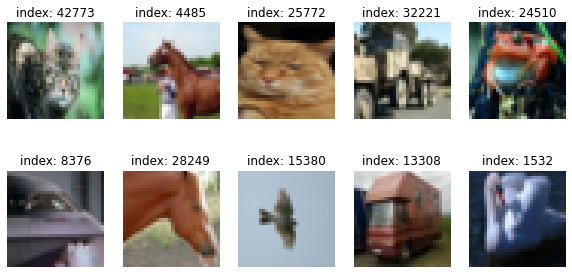

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    rn = np.random.randint(len(train_x))
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[rn])
    plt.title(f'index: {rn}')
    plt.axis('off')
# plt.imshow(train_x[0])
plt.show()

# 데이터 정규화

In [5]:
train_x.max(), train_x.min()

(255, 0)

In [6]:
train_x = (train_x - 127.5) / 127.5

train_x.max(), train_x.min()

(1.0, -1.0)

In [7]:
train_x[41611].max(), train_x[41611].min()

(1.0, -1.0)

# 이미지 출력

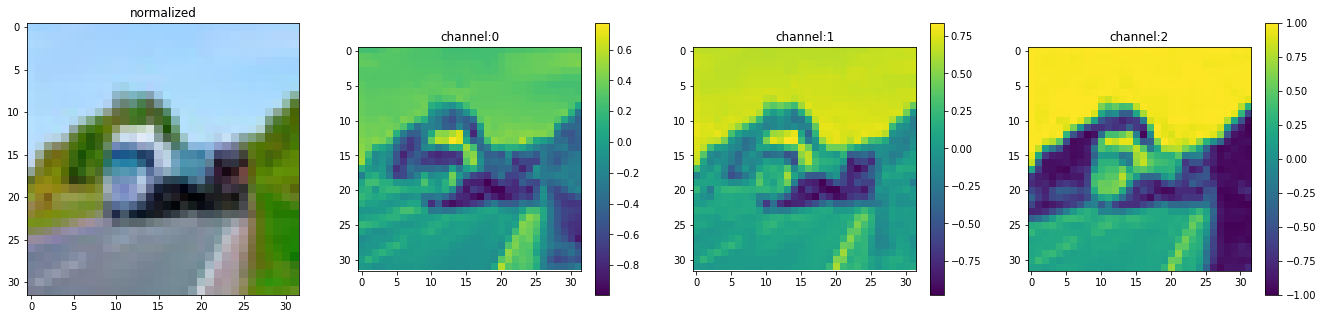

In [8]:
plt.figure(figsize=(23, 5))

plt.subplot(1, 4, 1)
plt.title("normalized")
plt.imshow((train_x[41611]+1)/2)

for i in range(3):
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(train_x[41611][:,:,i])
    plt.title('channel:{}'.format(i))
    plt.colorbar()
    
# plt.colorbar()
plt.show()

In [9]:
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 128

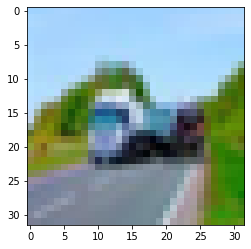

In [10]:
test_img = train_x[41611]
plt.imshow((test_img[:,:,:]+1) / 2)

In [11]:
test_img.shape

(32, 32, 3)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x, )
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [13]:
test_img = next(iter(train_dataset))

# 사이즈 별 이미지 차이확인

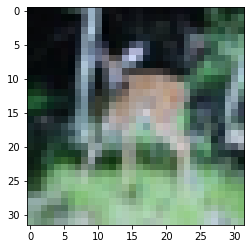

In [14]:
plt.imshow((test_img[0,:,:,:]+1)/2)

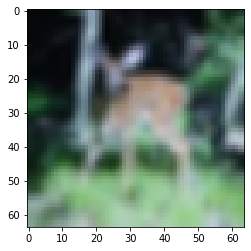

In [15]:
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64, interpolation='bilinear')(test_img)
plt.imshow((result1[0,:,:,:]+1)/2)

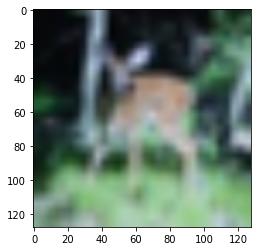

In [16]:
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(test_img)
plt.imshow((result2[0,:,:,:]+1)/2)

In [17]:
train_dataset = train_dataset.map(lambda x : tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(x))

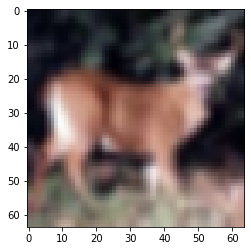

In [18]:
check = next(iter(train_dataset))
plt.imshow((check[0]+1)/2)
plt.show()

In [19]:
INPUT_SHAPE = (64, 64, 3)

# 텐서플로우 DCGAN 구현
---
# 생성자
## make_generator_model 함수 생성
- 이미지 사이즈 7 * 7 -> 8 * 8 변경 : 기존 32 * 32사이즈 2번의 업스케일링이 있기 때문에 8 * 8로 변경
- Conv2DTranspose() = Unpsampling + Conv2D / 업스케일링 2번 추가 8 -> 32
- leakyReLU() -> leakyReLU(0.2) 0보다 작을 경우 곱하라는 의미 : 음수 -> 양수
- 커널사이즈 변경 5, 5 -> 4, 4
- 컬러채널은(rgb) 3이므로 1 -> 3으로 변경

In [20]:
def make_generator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer    
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer    
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Conv2DTranspose layer   
    model.add(layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Sixth: Conv2DTranspose layer    
    # Color에는 rgb의 3개 채널이 있어야 하기 때문에 3으로 변경
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), padding='same', use_bias=False, activation='tanh'))
    
    return model

**DCGAN에서 maxpooling을 최대하 배제하는 이유 - 이미지의 위치 정보를 잃어버린다는 단점 때문에**

DCGAN의 특징은 몇 가지로 요약할 수 있다. 먼저, 선형 레이어와 풀링 레이어(Pooling Layer)를 최대한 배제하고 합성곱(Convolution)과 ‘Transposed Convolution(Fractional-Strided Convolution)’으로 네트워크 구조를 만들었다. 풀링 레이어는 여러 딥러닝 모델에서 불필요한 매개변수의 수를 줄이고 중요한 특징만을 골라내는 역할을 하는 레이어지만 이미지의 위치 정보를 잃어버린다는 단점이 있다. 이미지를 생성하기 위해서는 위치 정보가 중요하기 때문에 DCGAN은 풀링 레이어를 배제했다. 선형 레이어 역시 마찬가지로 위치 정보를 잃어버리므로 모델의 깊은 레이어에서는 선형 레이어를 사용하지 않았다.

# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력

In [21]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262144    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0

# 이미지

(1, 64, 64, 3)
0.016303413 -0.015440979


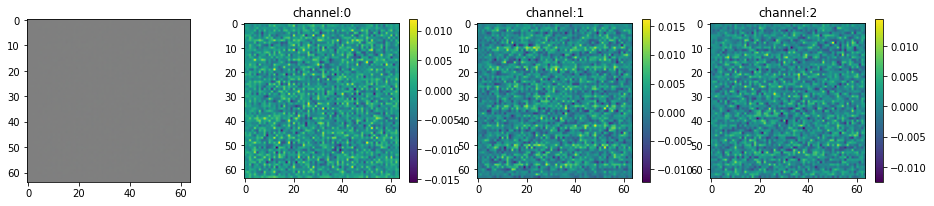

In [22]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
print(np.max(generated_image[0]), np.min(generated_image[0]))

plt.figure(figsize=(16, 3))
plt.subplot(1, 4, 1)
plt.imshow((generated_image[0, :, :, :]+1)/2)
for i in range(3) :
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(generated_image[0, :, :, i])
    plt.title("channel:{}".format(i))
    plt.colorbar()
plt.show()

In [23]:
INPUT_SHAPE

(64, 64, 3)

# 텐서플로우 DCGAN 구현
---
# 판별자

In [24]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=INPUT_SHAPE))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D layer    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth : Conv2D layer   
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fifth: Conv2D layer   
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    
    # End  Layer
    model.add(layers.Dense(1))

    return model

In [25]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)      

In [26]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00043314]], dtype=float32)>

# 손실함수와 최적화 함수
## 손실함수(loss function)
### GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용
### 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용
# 손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있습니다.

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용합니다.

fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

# generator_loss

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator_loss

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# discriminator accuracy

In [30]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# 최적화 함수(optimizer)

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


샘플은 한 번에 16장을 생성하도록 하겠습니다.
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [32]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 설계

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [33]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator가 이미지를 생성
        generated_images = generator(noise, training=True)
        
        # discriminator가 실제 입력받은 이미지로는 real_output
        # 위에서 생성한 이미지에 대해서는 fake_output을 계산해서 return
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 real_output, fake_output 두 개를 받아서 연산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy계산해서 real, fake에 대한 accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    
    # gradient를 계산하는 부분, gen+tape와 disc_tape를 활용해서 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 위에서 계산된 optimzer에 입력해서 가중치를 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보죠.
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

# generate_and_save_images 함수 생성

In [34]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    # 이부분을 그려주는게 달라져야 할듯
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
               .format(os.getenv('HOME'), epoch, it))
    
    plt.show()

subplot을 이용해서 총 16개의 sample을 시각화하는 과정입니다. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화하는 것이죠.

# draw_train_history 함수 생성

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지파일로 저장한다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04}.png'
               .format(os.getenv("HOME"), epoch))
    plt.show()

# training_checkpoints

In [ ]:
checkpoint_dir = os.getenv("HOME") + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

# 학습 시키기

In [37]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

In [40]:
save_every = 10
EPOCHS = 10

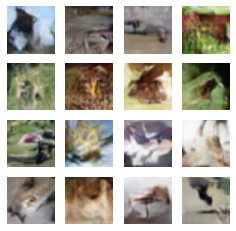

Time for training : 1596 sec


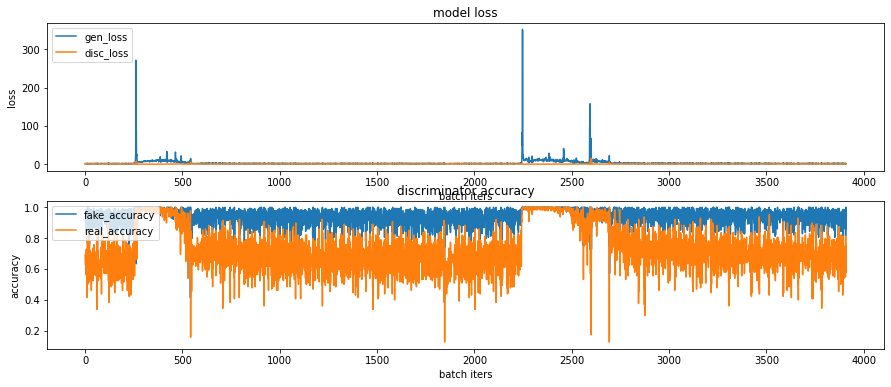

CPU times: user 27min 1s, sys: 23.1 s, total: 27min 24s
Wall time: 26min 36s


In [41]:
%%time
train(train_dataset, EPOCHS, save_every)

In [42]:
save_every = 10
EPOCHS = 20

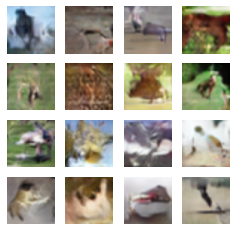

Time for training : 3191 sec


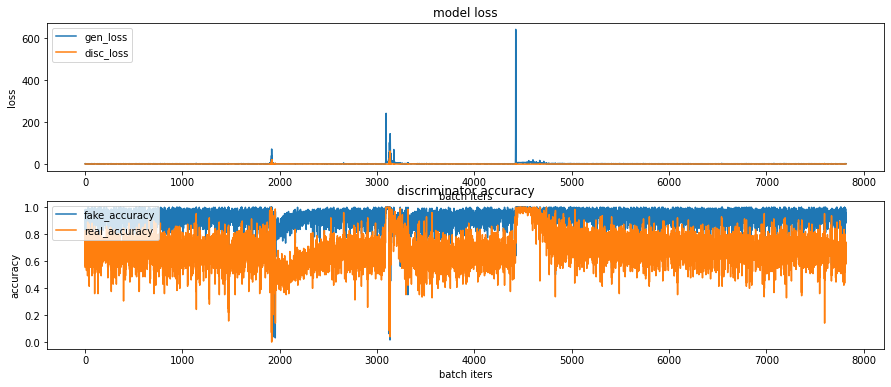

CPU times: user 54min 1s, sys: 46.8 s, total: 54min 47s
Wall time: 53min 11s


In [43]:
%%time
train(train_dataset, EPOCHS, save_every)

In [38]:
save_every = 10
EPOCHS = 100

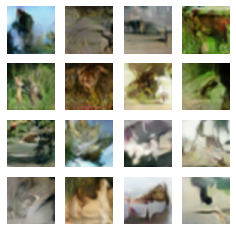

Time for training : 16050 sec


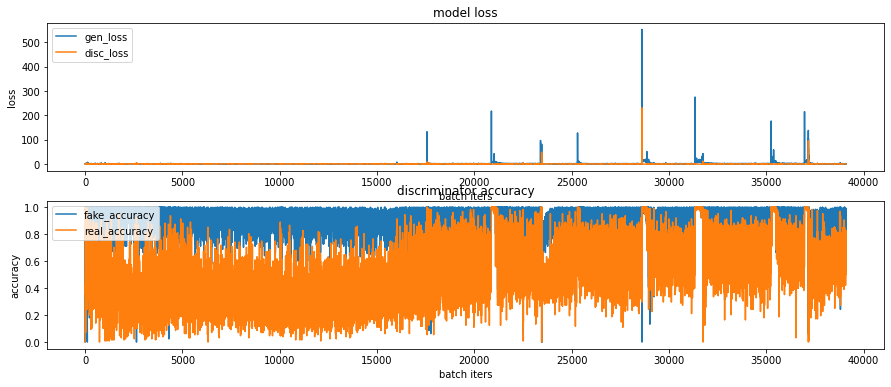

CPU times: user 4h 31min 35s, sys: 3min 53s, total: 4h 35min 28s
Wall time: 4h 27min 32s


In [39]:
%%time
train(train_dataset, EPOCHS, save_every)

회고
---
프로젝트 전 학습한 내용
https://github.com/85honesty/AIFFEL/blob/main/Exploration_10/E-10%5DGAN.ipynb

에포크의 변화량이 증가함에 따라 이미지의 개선을 보였으며 fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인 하지 못하였다.
정규분포(가우시안 분포),스트라이드 크기로 나누어질 수 있는 커널 크기를 사용,무작위성이 모델을 견고하게 만든다는데 다음에 구현하게 되면 이점을 참고하고 싶다.


학습 과정 진행하기까지는 진행을 했지만 GAN 훈련 과정 개선하기에는 진행을 하지 못했다.
추가적인 학습이 필요함을 느꼈다.

참고 문헌과 사이트

---
모두의 딥러닝https://dreamgonfly.github.io/blog/gan-explained/ https://github.com/Development-On-Saturday/AIFFEL_Exploration_Reference/blob/main/exp_12/notebooks/exp_12_v1.ipynb